In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set()


In [21]:
basmi = pd.read_csv('../../data/clean_full.csv', index_col=0, parse_dates=[1])
basmi.head()

,norm_years,gender,BS,Age,Drug,year,time_since_diagnosis
patient_id,,,,,,,
40,0,Female,3.1,48,False,1995,1.0
40,1,Female,2.4,49,False,1996,2.0
40,2,Female,3.0,50,False,1997,3.0
40,3,Female,3.4,51,False,1998,4.0
40,4,Female,3.3,52,False,1999,5.0


### Patients who progress


In [8]:
from sklearn.linear_model import LinearRegression

def trend(bs_scores, time):
    y = np.asarray(bs_scores)
    X = np.asarray(time).reshape(-1, 1)
    lm = LinearRegression(fit_intercept=True)
    lm.fit(X, y)
    return lm

def predict_and_plot(scores):
    X = np.asarray(scores).reshape(-1, 1)
    preds = lrm.predict(X)
    plt.plot(range(len(scores)), scores, c='r')
    plt.plot(range(len(scores)), preds, c='b')
    plt.show()
    
normed_bs = pd.read_excel('../../data/bs_normed_full.xls')

patient_models = {}
patient_grads = {}
for patient_id, patient_df in normed_bs.groupby('patient_id'):
    lrm = trend(patient_df['BS'], patient_df['norm_years'])
#     predict_and_plot(patient_df['BS'])
    patient_models[patient_id] = lrm
    patient_grads[patient_id] = lrm.coef_[0]

In [9]:
grads = pd.DataFrame.from_dict(patient_grads, orient='index')
grads.rename(columns={0: 'BS_grad'}, inplace=True)

patients_who_progress = grads[grads['BS_grad'] > 0]

In [13]:
progress_df = basmi.loc[patients_who_progress.index]
progress_df.head()

,Date,CRS,TWS,LSFS,LFS,IMS,BS,Drug
patient_id,,,,,,,,
40,1995-05-09,3,1,6,5,3,3.6,NaN
40,1995-06-01,3,1,8,5,3,4.0,NaN
40,1995-06-12,2,1,5,3,2,2.6,NaN
40,1995-11-02,1,1,3,4,2,2.2,NaN
40,1996-05-02,2,1,4,3,2,2.4,NaN


In [12]:
basmi.head()

,Date,CRS,TWS,LSFS,LFS,IMS,BS,Drug
patient_id,,,,,,,,
40,1995-05-09,3,1,6,5,3,3.6,NaN
40,1995-06-01,3,1,8,5,3,4.0,NaN
40,1995-06-12,2,1,5,3,2,2.6,NaN
40,1995-11-02,1,1,3,4,2,2.2,NaN
40,1996-05-02,2,1,4,3,2,2.4,NaN


In [10]:
def get_diff(df_):
    df = df_.copy()
    df['Date_diff'] = df['Date'].diff().dt.days
    df['BS_diff'] = df['BS'].diff()
    return df.iloc[1:] # return from 1-> to drop first nan

basmi_diff = basmi.groupby('patient_id').apply(get_diff)
basmi_diff.reset_index(level=0, drop=True, inplace=True)

basmi_diff['BS_per_day'] = basmi_diff['BS_diff'] / basmi_diff['Date_diff']

basmi_diff.head()

,Date,CRS,TWS,LSFS,LFS,IMS,BS,Drug,Date_diff,BS_diff,BS_per_day
patient_id,,,,,,,,,,,
40,1995-06-01,3,1,8,5,3,4.0,NaN,23.0,0.4,0.017391
40,1995-06-12,2,1,5,3,2,2.6,NaN,11.0,-1.4,-0.127273
40,1995-11-02,1,1,3,4,2,2.2,NaN,143.0,-0.4,-0.002797
40,1996-05-02,2,1,4,3,2,2.4,NaN,182.0,0.2,0.001099
40,1997-02-06,3,1,5,4,2,3.0,NaN,280.0,0.6,0.002143


### Show distribution of waiting times

The waiting time is the time between measurements



A preview of the data sorted by Date_diff: (Note the value of Date_diff)



,Date,CRS,TWS,LSFS,LFS,IMS,BS,Drug,Date_diff,BS_diff,BS_per_day
patient_id,,,,,,,,,,,
7766,1996-09-12,1,1,0,2,2,1.2,NaN,1.0,0.0,0.0
3936,1989-02-18,1,0,9,2,3,3.0,NaN,1.0,0.0,0.0
3936,1989-01-31,1,1,9,2,4,3.4,NaN,1.0,0.0,0.0
1716,1987-11-13,5,3,9,5,5,5.4,NaN,1.0,-0.6,-0.6
3824,1997-02-27,3,1,5,7,2,3.6,NaN,1.0,0.0,0.0


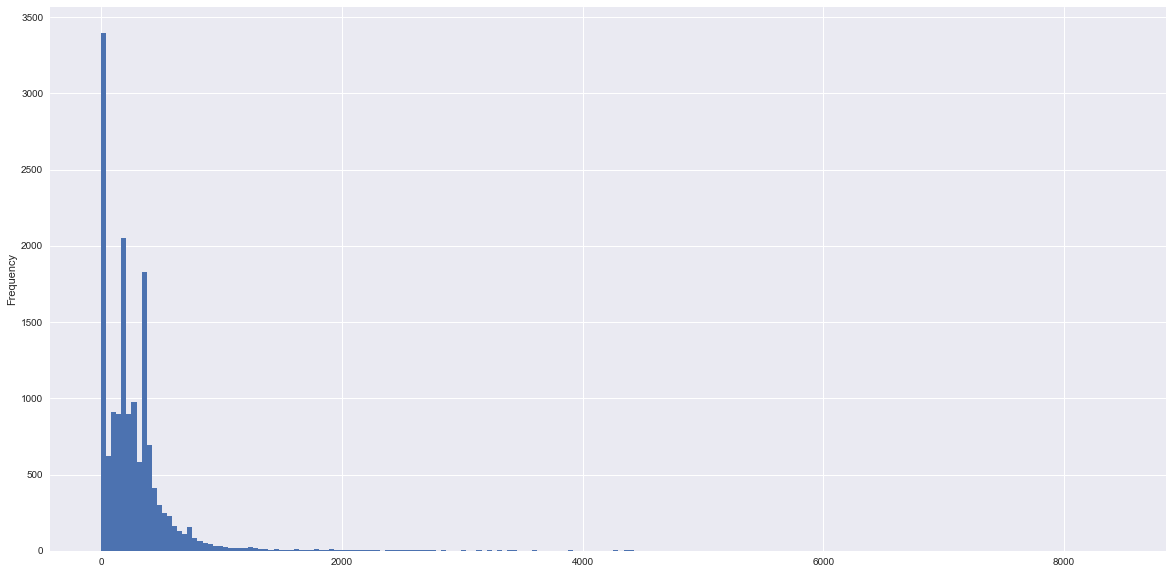

In [11]:
basmi_diff['Date_diff'].plot(kind='hist', bins=200, figsize=(20,10))

print('\n\nA preview of the data sorted by Date_diff: (Note the value of Date_diff)\n')
basmi_diff.sort_values(by='Date_diff').head()

Interesting, an _overwhelming_ number of patients had measurements 1 day apart, which was unexpected. 

Lets see how the graph looks if we plot for all values greater than 1 and less than 1000:

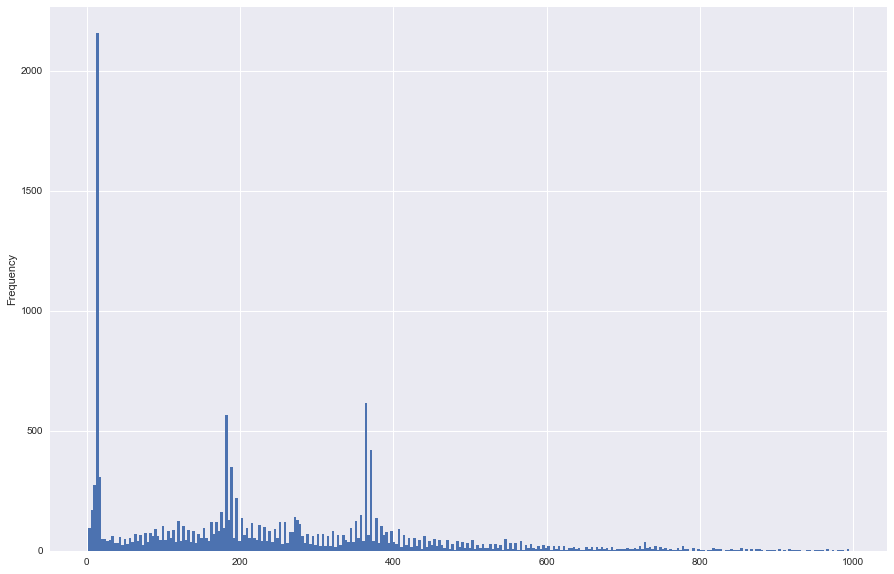

In [43]:
filtered = basmi_diff[(basmi_diff['Date_diff'] > 1) & (basmi_diff['Date_diff'] < 1000)]
filtered['Date_diff'].plot(kind='hist',bins=300, figsize=(15,10))

Some interesting harmonics there...lets take a look at the actual frequencies of the top 10 intervals


In [45]:
filtered['Date_diff'].value_counts().head(10)

13.0     1380
12.0      569
364.0     401
182.0     322
371.0     314
189.0     197
14.0      182
18.0      177
11.0      162
183.0     130
Name: Date_diff, dtype: int64

#### Waiting Time Analysis:

So there are 1380 patients who had measurements taken 13 days apart and 570 who were measured 12 days apart.

Knowing that rehab patients are measured 14 days apart, is it possible that these patients exited the rehab earlier and were measured  11/12/13 days apart instead of 14?

Another interesting thing: The 3rd highest frequency period is 364 days - exactly one year apart, the and the 4th is 182, which is half a year apart. 

@Raj, were you expecting these insights?